# Piecewise polynomial regression

Inspired by the example in
> Fearnhead, Paul, and Zhen Liu. "Efficient Bayesian analysis of multiple changepoint models with dependence across segments." Statistics and Computing 21 (2011): 217-229.


In [1]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## The choice of (M.1)

In [3]:
import chex
import einops
import distrax
from jax.flatten_util import ravel_pytree
from rebayes_mini.states import GaussState
from rebayes_mini.methods.adaptive import GaussPositionRLPR, Runlength
from rebayes_mini.methods.gauss_filter import ExtendedKalmanFilter, BeliefExtendedKalmanFilter

In [4]:
from rebayes_mini.callbacks import get_null

In [5]:
@chex.dataclass
class SBOCDPGaussState:
    """
    State for a
    Bayesian online changepoint detection with position (BOCDP)
    with Gaussian posterior
    """
    mean: chex.Array
    cov: chex.Array
    log_joint: chex.Array
    runlength: chex.Array
    last_x: chex.Array
    log_posterior: chex.Array

In [39]:
class SoftPiecewiseRLPR(Runlength):
    """
    Greedy runlength with prior reset (RL-PR)
    """
    def __init__(
            self, p_change, filter, deflate_mean, threshold=1/2, shock=1.0
    ):
        super().__init__(p_change, K=1)
        self.filter = filter
        self.deflate_mean = deflate_mean
        self.shock = shock
        self.threshold = threshold

    def init_bel(self, mean, cov, log_joint_init, x_init):
        state_filter = self.filter.init_bel(mean, cov)
        mean = state_filter.mean
        cov = state_filter.cov

        bel = SBOCDPGaussState(
                mean=einops.repeat(mean, "i -> k i", k=self.K),
                cov=einops.repeat(cov, "i j -> k i j", k=self.K),
                log_joint=(jnp.ones((self.K,)) * -jnp.inf).at[0].set(log_joint_init),
                runlength=jnp.zeros(self.K),
                log_posterior=jnp.zeros(self.K),
                last_x=jnp.ones(self.K) * x_init
        )

        return bel

    def log_predictive_density(self, y, X, bel):
        """
        compute the log-posterior predictive density
        of the moment-matched Gaussian
        """
        mean  = self.filter.vobs_fn(bel.mean, X, bel).astype(float)
        Rt = self.filter.observation_covariance
        Ht = self.filter.jac_obs(bel.mean, X, bel)
        covariance = Ht @ bel.cov @ Ht.T + Rt
        mean = jnp.atleast_1d(mean)
        log_p_pred = distrax.MultivariateNormalFullCovariance(mean, covariance).log_prob(y)
        return log_p_pred

    def update_bel(self, y, X, bel):
        bel, _ = self.filter.step(bel, y, X, get_null)
        return bel

    def update_log_joint(self, y, X, bel, bel_prior):
        log_joint_reset = self.update_log_joint_reset(y, X, bel, bel_prior)
        log_joint_increase = self.update_log_joint_increase(y, X, bel)
        # Expand log-joint
        log_joint = jnp.concatenate([log_joint_reset, log_joint_increase])
        log_joint = jnp.nan_to_num(log_joint, nan=-jnp.inf, neginf=-jnp.inf)
        # Compute log-posterior before reducing
        log_posterior = log_joint - jax.nn.logsumexp(log_joint)

        # Decide whether to reset or discount parameters
        # log-posterior is a two-dimensional vector
        # ix 0 — reset | ix 1 — update
        posterior_update = jnp.exp(log_posterior)[1]
        ix_select = jnp.array([
            1 * (posterior_update > self.threshold) +
            0 * (posterior_update <= self.threshold)
        ])
        log_joint = log_joint[ix_select]
        log_posterior = log_posterior[ix_select]
        top_indices = ix_select
        
        return log_posterior, log_joint, top_indices


    def deflate_belief(self, bel, bel_prior):
        gamma = jnp.exp(bel.log_posterior)
        dim = bel.mean.shape[0]
        deflate_mean = gamma ** self.deflate_mean

        new_mean = bel.mean * deflate_mean
        new_cov = bel.cov * gamma ** 2 + (1 - gamma ** 2) * jnp.eye(dim) * self.shock
        bel = bel.replace(mean=new_mean, cov=new_cov)
        return bel


    def step(self, y, X, bel, bel_prior, callback_fn):
        """
        Update belief state and log-joint for a single observation
        """
        bel_prior = bel_prior.replace(
            last_x=jnp.squeeze(X)
        )
        
        log_posterior, log_joint, top_index = self.update_log_joint(y, X, bel, bel_prior)
        bel_posterior = jax.vmap(self.deflate_belief, in_axes=(0, None))(bel, bel_prior)
        bel_posterior = self.update_beliefs(y, X, bel_posterior, bel_prior)
        bel_posterior = bel_posterior.replace(log_joint=log_joint, log_posterior=log_posterior)
        bel_posterior = jax.tree.map(lambda param: param[top_index], bel_posterior)

        out = callback_fn(bel_posterior, bel, y, X)

        return bel_posterior, out

## Data generation

In [7]:
key = jax.random.PRNGKey(314)
key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

In [8]:
def sample_partitions(key, p, n_partitions):
    partitions = jax.random.geometric(key, p, shape=(n_partitions,)).cumsum()
    partitions = jnp.insert(partitions, 0, 0)
    return partitions


def sample_covariates(key, n_samples, minval=-5, maxval=5):
    x = jax.random.uniform(key, minval=minval, maxval=maxval, shape=(n_samples,))
    x = jnp.sort(x)
    return x

In [9]:
def sample_measurements(keys_noise, keys_params, partitions, x, std_measurement, n_power=3):
    powers = jnp.arange(n_power) # dimensionality of feature space
    y = []
    y_clean_hist = []
    pair_partitions = list(zip(partitions[:-1], partitions[1:]))
    for k, (ix_init, ix_end) in enumerate(pair_partitions):
        
        if k == 0:
            mean_next = jnp.zeros(n_power)
            sigma_params = jnp.ones(n_power)
        else:
            ix_init_prev = pair_partitions[k-1][0]
            delta = x[ix_init] - x[ix_init_prev]

            # Mean in new segment --- create dependence from previous segment
            mean_next = jnp.zeros(n_power)
            mean_next = mean_next.at[0].set(params @ jnp.power(delta, powers))

            # Variance in new segment --- enforce dependence by setting
            #  variance of first term (bias) to be zero
            sigma_params = jnp.ones(n_power)
            sigma_params = sigma_params.at[0].set(0.0)
        
        x_sub = x[ix_init:ix_end]
        n_sub = len(x_sub)
        H_sub = jnp.power((x_sub - x_sub[0])[:, None], powers[None,:])
        
        key_param = jax.random.fold_in(keys_params, k)
        key_noise = jax.random.fold_in(keys_noise, k)
        
        params = jax.random.normal(key_param, (n_power,)) * sigma_params + mean_next
        noise = jax.random.normal(key_noise, (n_sub,)) * std_measurement

        y_clean = H_sub @ params
        y_sub = y_clean + noise
    
        y_clean_hist.append(y_clean)
        y.append(y_sub)
        
    y = jnp.concat(y)
    y_clean_hist = jnp.concat(y_clean_hist)
    return y, y_clean_hist

In [10]:
p = 0.01
n_partitions = 5
std_measurements = 0.2
partitions = sample_partitions(key_partition, p, n_partitions)
n_samples = partitions[-1]
x = sample_covariates(key_x, n_samples)
y, y_clean = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=std_measurements, n_power=3)
pair_partitions = list(zip(partitions[:-1], partitions[1:]))

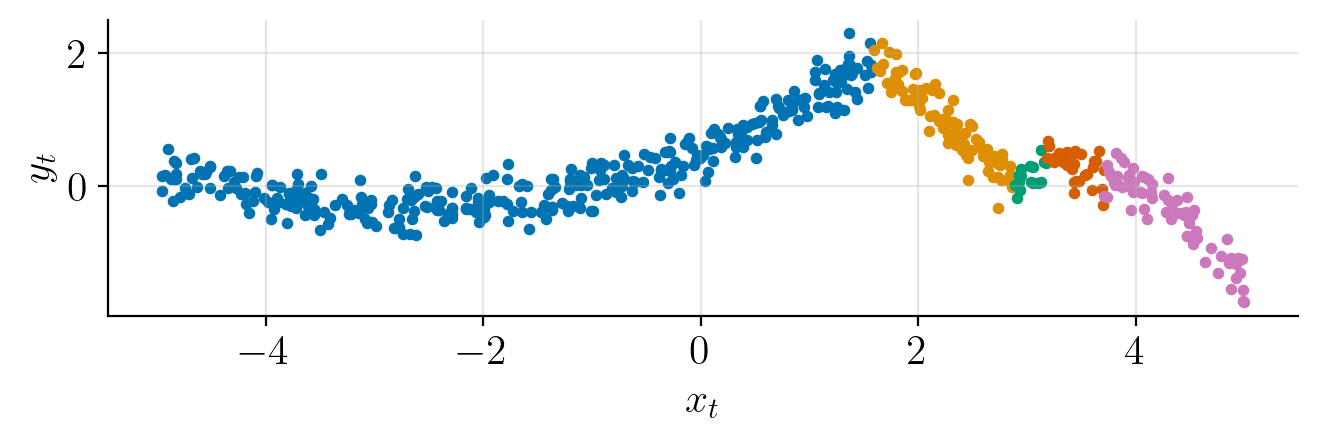

In [11]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))

colors = sns.color_palette()
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ymin, ymax = plt.ylim()
plt.grid(alpha=0.3)

## Building the measurment model

In [12]:
def build_features(x, last_x):
    delta = x - last_x
    phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
    return phi

def apply_fn(mean, x, bel):
    phi = build_features(x, bel.last_x)
    return mean @ phi

In [16]:
def callback(bel, bel_prior, y, X):
    log_posterior = bel_prior.log_joint - jax.nn.logsumexp(bel_prior.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)

    pred_values = jax.vmap(apply_fn, in_axes=(0, None, 0))(bel_prior.mean, X, bel_prior)
    pred = posterior @ pred_values

    Ht = build_features(X, bel_prior.last_x)
    var_pred = jnp.einsum("nk,knm,mk,k->", Ht, bel_prior.cov, Ht, posterior)
    var_pred = var_pred + std_measurements ** 2
    
    out = {
        "log_joint": bel.log_joint,
        "runlength": bel.runlength,
        "err": pred - y,
        "yhat": pred,
        "yhat_var": var_pred,
    }
    return out

## RL with moment matching

In [17]:
# ExtendedKalmanFilterFeatures
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=std_measurements ** 2
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=1, filter=filter, moment_match=True)

In [18]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_mm = afilter.scan(y[:, None], x[:, None], bel_init, callback)

In [19]:
log_posterior = hist_mm["log_joint"] - jax.nn.logsumexp(hist_mm["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [20]:
jnp.sqrt(jnp.power(hist_mm["err"], 2).mean())

Array(0.45395893, dtype=float32)

In [21]:
hist_mm["yhat_var"].shape

(560,)

In [22]:
ymin_mm = hist_mm["yhat"].squeeze() - 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())
ymax_mm = hist_mm["yhat"].squeeze() + 2 * jnp.sqrt(hist_mm["yhat_var"].squeeze())

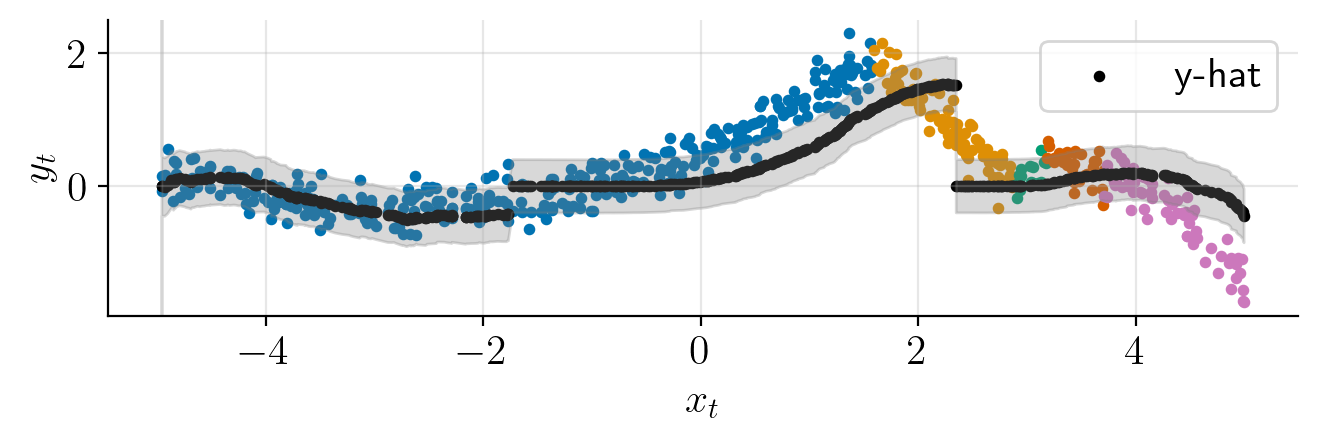

In [23]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_mm["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

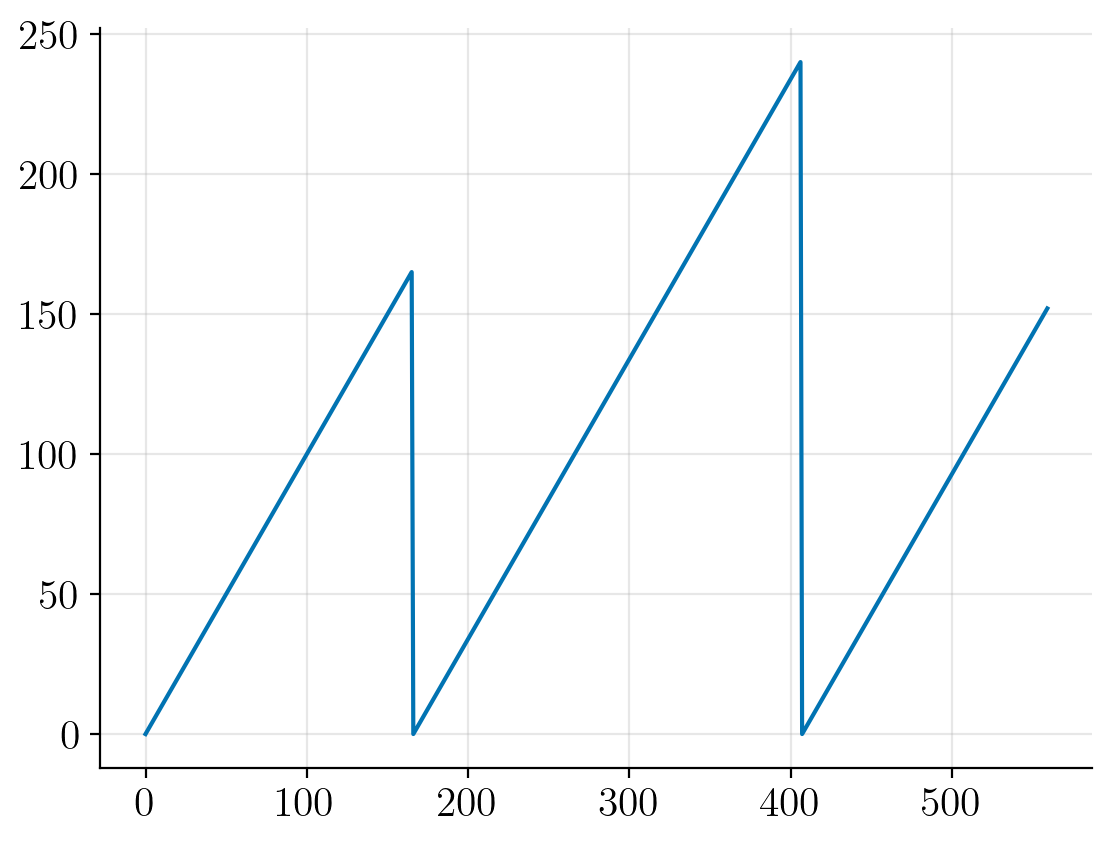

In [24]:
expected_runlength_rlmmpr = jnp.einsum("tk,tk->t", hist_mm["runlength"], posterior)
plt.plot(expected_runlength_rlmmpr)
plt.grid(alpha=0.3)

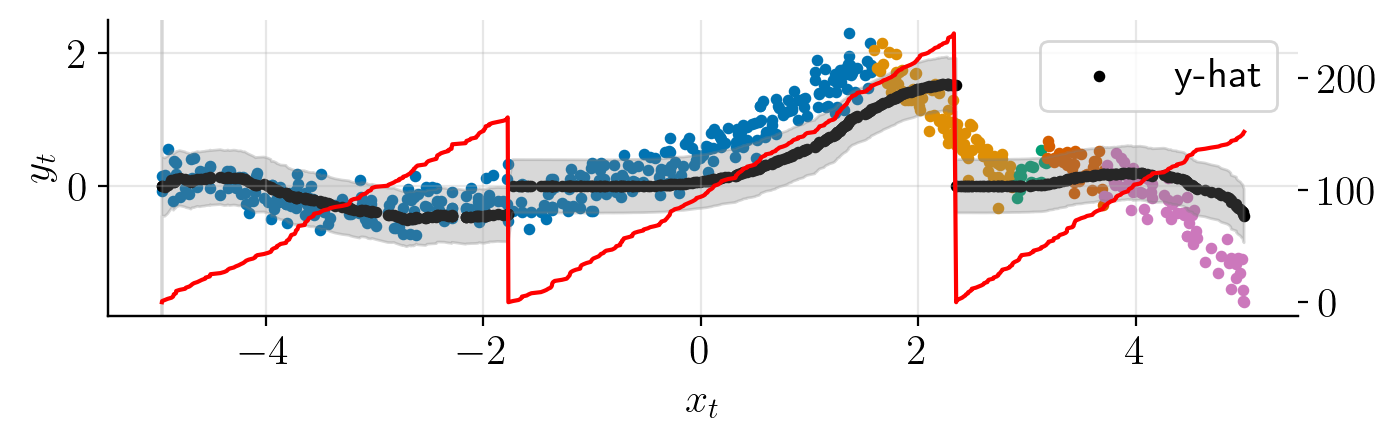

In [25]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_mm["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlmmpr, c="red")

## RL without moment-matching

In [26]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=0.2 ** 2
)
p_change = 0.01
afilter = GaussPositionRLPR(p_change, K=1, filter=filter, moment_match=False)

In [27]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = afilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_rlpr = afilter.scan(y[:, None], x[:, None], bel_init, callback)

In [28]:
log_posterior = hist_rlpr["log_joint"] - jax.nn.logsumexp(hist_rlpr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

In [29]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(0.8624169, dtype=float32)

In [30]:
ymin_rlpr = hist_rlpr["yhat"].squeeze() - 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())
ymax_rlpr = hist_rlpr["yhat"].squeeze() + 2 * jnp.sqrt(hist_rlpr["yhat_var"].squeeze())

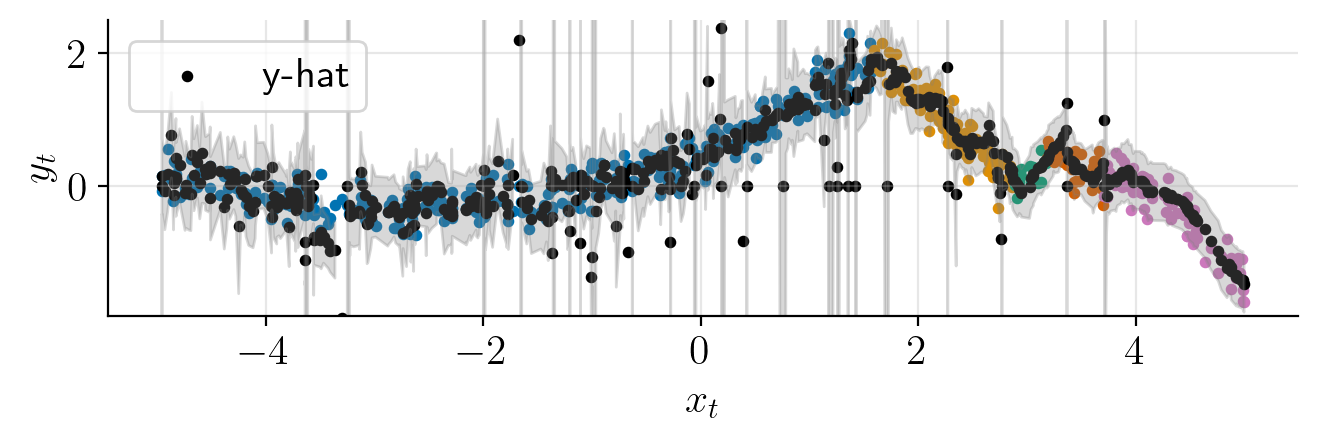

In [31]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_rlpr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

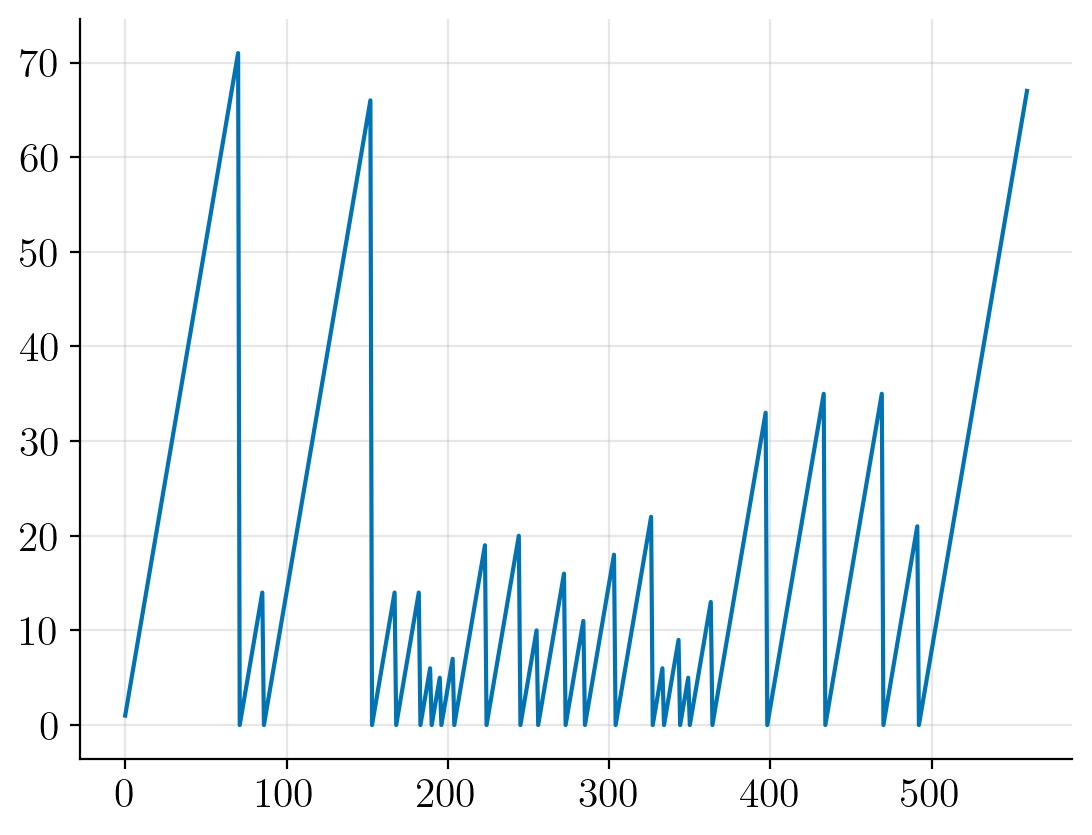

In [32]:
expected_runlength_rlpr = jnp.einsum("tk,tk->t", hist_rlpr["runlength"], posterior)
plt.plot(expected_runlength_rlpr)
plt.grid(alpha=0.3)

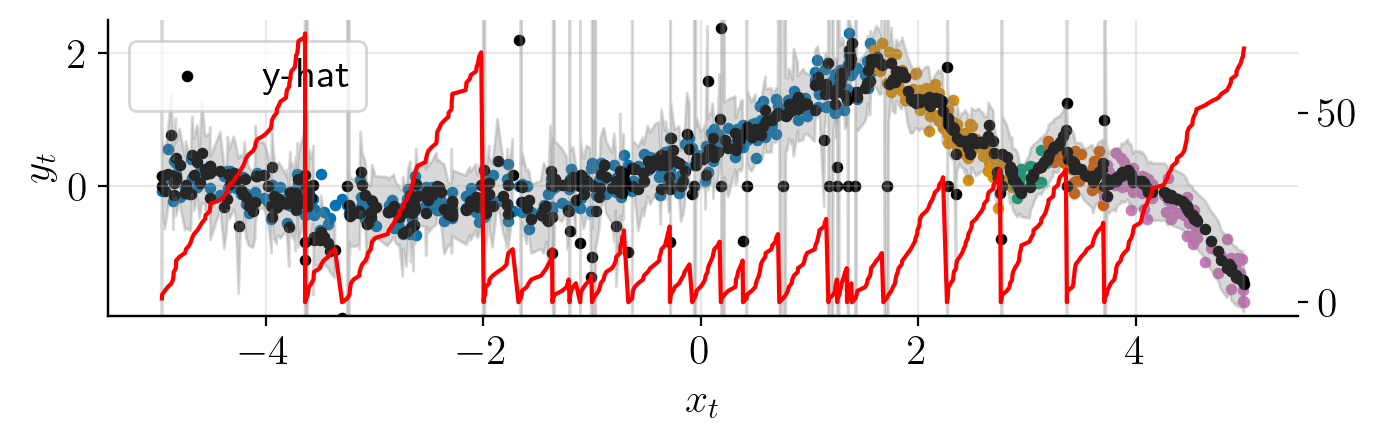

In [33]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_rlpr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlpr, c="red")

## Soft-prior reset

In [40]:
filter = BeliefExtendedKalmanFilter(
    lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=0.2 ** 2
)
p_change = 0.01
sfilter = SoftPiecewiseRLPR(p_change, filter=filter, deflate_mean=True, threshold=0.001)

In [41]:
mean = jnp.zeros(3)
cov = jnp.eye(3) * 1.0

bel_init = sfilter.init_bel(mean, cov, 0.0, x[-1])
bel_final, hist_spr = sfilter.scan(y[:, None], x[:, None], bel_init, callback)

In [42]:
ymin_spr = hist_spr["yhat"].squeeze() - 2 * jnp.sqrt(hist_spr["yhat_var"].squeeze())
ymax_spr = hist_spr["yhat"].squeeze() + 2 * jnp.sqrt(hist_spr["yhat_var"].squeeze())

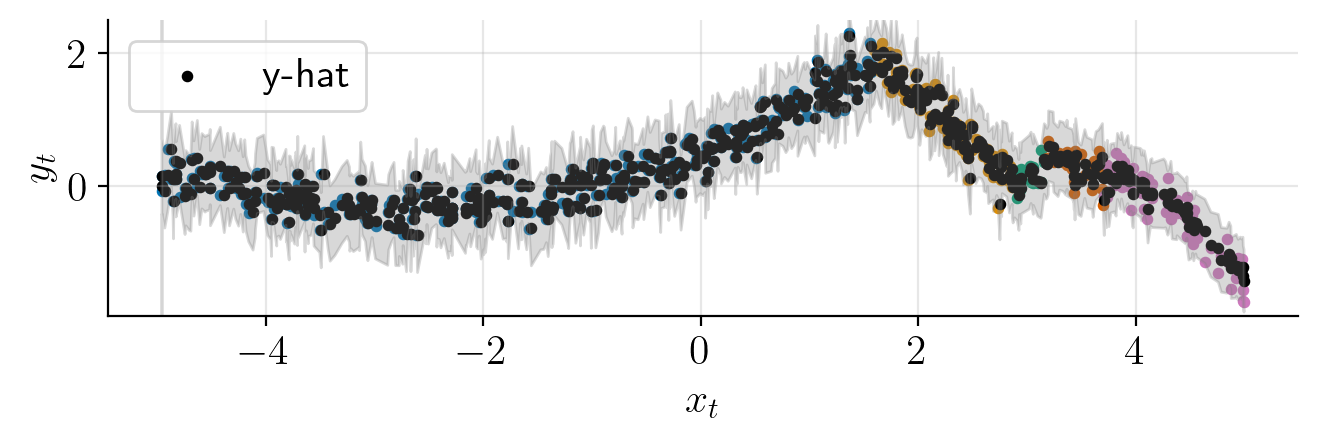

In [43]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
# fig, ax = plt.subplots()

for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_spr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

In [44]:
jnp.sqrt(jnp.power(hist_spr["err"], 2).mean())

Array(0.27549142, dtype=float32)

In [45]:
log_posterior = hist_spr["log_joint"] - jax.nn.logsumexp(hist_spr["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

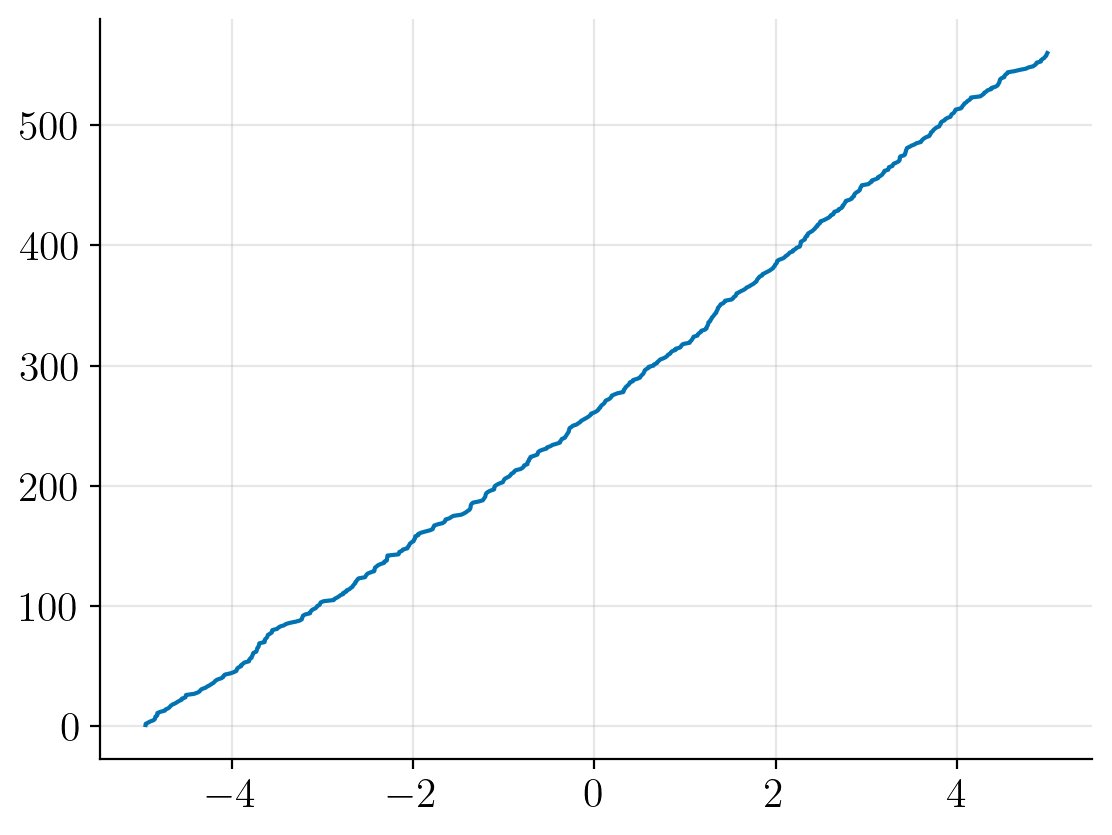

In [46]:
expected_runlength_rlspr = jnp.einsum("tk,tk->t", hist_spr["runlength"], posterior)
plt.plot(x, expected_runlength_rlspr)
plt.grid(alpha=0.3)

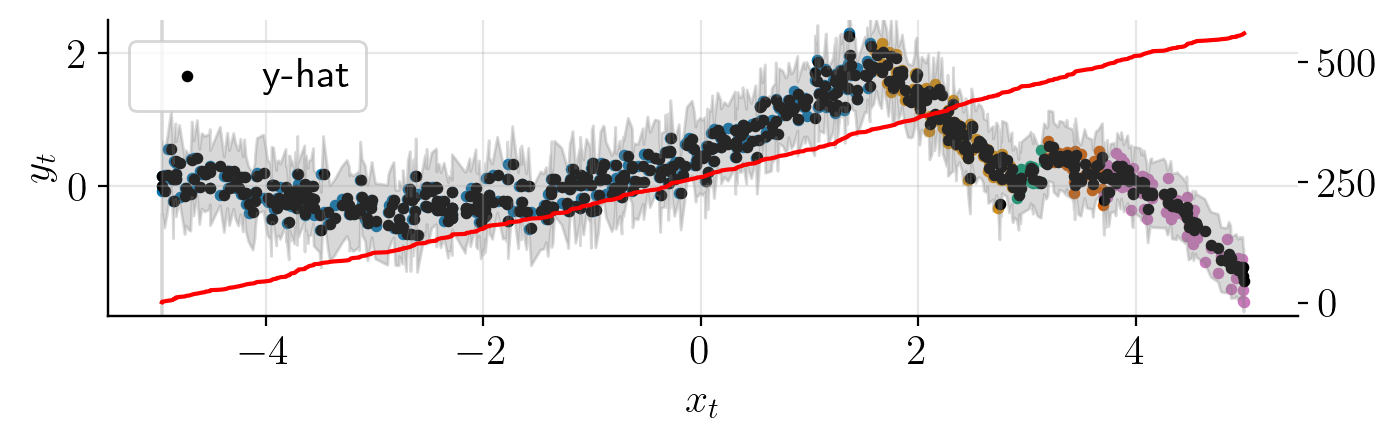

In [47]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))
ax2 = ax.twinx()
# fig, ax = plt.subplots()

plt.sca(ax)
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        ax.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)

ax.scatter(x, hist_spr["yhat"], s=10, label="y-hat", c="black")
ax.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)

ax.legend()
plt.ylim(ymin, ymax)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ax.grid(alpha=0.3)

ax2.plot(x, expected_runlength_rlspr, c="red")

## Comparison plot

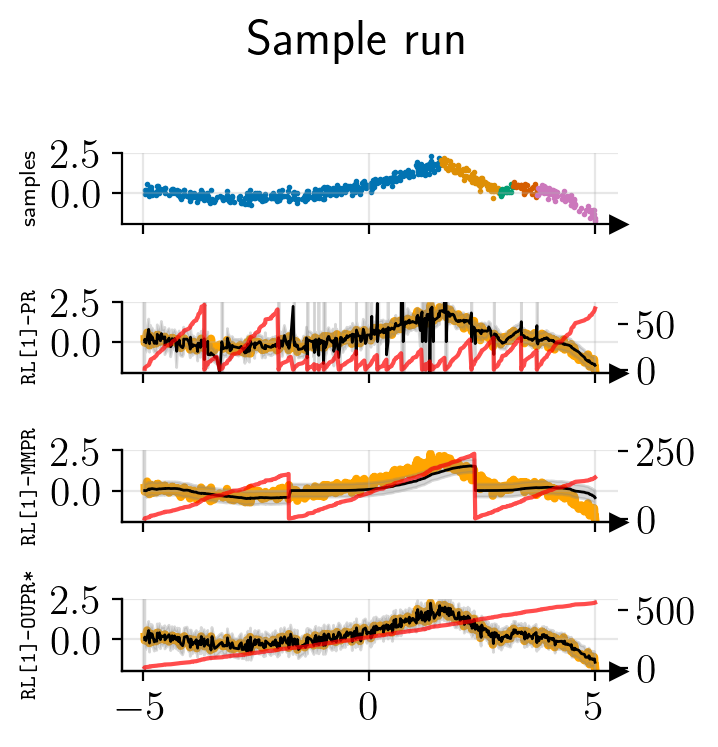

In [48]:
fig, axs = plt.subplots(4, 1, figsize=(6.4 * 1.2 * 0.5, 4.8 * 0.8), sharey=True, sharex=True)

markersize = 1
axs = axs.ravel()
plt.sca(axs[0])
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=markersize)

plt.sca(axs[1])
# plt.scatter(x, hist_rlpr["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_rlpr["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_rlpr, ymax_rlpr, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)
ax2 = axs[1].twinx()
ax2.plot(x, expected_runlength_rlpr, c="red", alpha=0.7)

plt.sca(axs[2])
# plt.scatter(x, hist_mm["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_mm["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_mm, ymax_mm, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)
ax2 = axs[2].twinx()
ax2.plot(x, expected_runlength_rlmmpr, c="red", alpha=0.7)

ax = axs[3]
plt.sca(axs[3])
# ax.scatter(x, hist_spr["yhat"], s=markersize, label="y-hat", c="black")
plt.plot(x, hist_spr["yhat"], linewidth=1, label="y-hat", c="black")
plt.fill_between(x, ymin_spr, ymax_spr, color="gray", alpha=0.3)
plt.ylim(ymin, ymax)

ax2 = axs[3].twinx()
ax2.plot(x, expected_runlength_rlspr, c="red", alpha=0.7)

titles = ["samples", r"$\texttt{RL[1]-PR}$", r"$\texttt{RL[1]-MMPR}$", r"$\texttt{RL[1]-OUPR*}$"]
for ax, title in zip(axs, titles):
    ax.grid(alpha=0.3)
    color_text = "black"
    # if "samples" in title:
    #     color_text = "black"
    # elif "SPR" in title:
    #     color_text = "teal"
    # else:
    #     color_text = "crimson"
    
    ax.set_ylabel(title, color=color_text, fontsize=8)

plt.tight_layout()
# plt.xlabel("$x_t$")
xmin, xmax = plt.xlim()

for i, ax in enumerate(axs):
    if i > 0:
        ax.plot(x, y, c="orange", linewidth=3, zorder=0)
    ax.plot(xmax, ymin, ">k", clip_on=False)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin, xmax)

plt.suptitle("Sample run")
plt.tight_layout()
plt.savefig(f"../figures/segment-dependency-sample.png", dpi=300, bbox_inches="tight")

## An animation

In [49]:
from matplotlib.animation import FuncAnimation

In [50]:
package = {
    "RL-MMPR": (hist_mm["yhat"], ymin_mm, ymax_mm, expected_runlength_rlmmpr),
    "RL-PR": (hist_rlpr["yhat"], ymin_rlpr, ymax_rlpr, expected_runlength_rlpr),
    "RL-OUPR": (hist_spr["yhat"], ymin_spr, ymax_spr, expected_runlength_rlspr)
}
package = jax.tree.map(np.array, package)

In [51]:
x = np.array(x)
y = np.array(y)

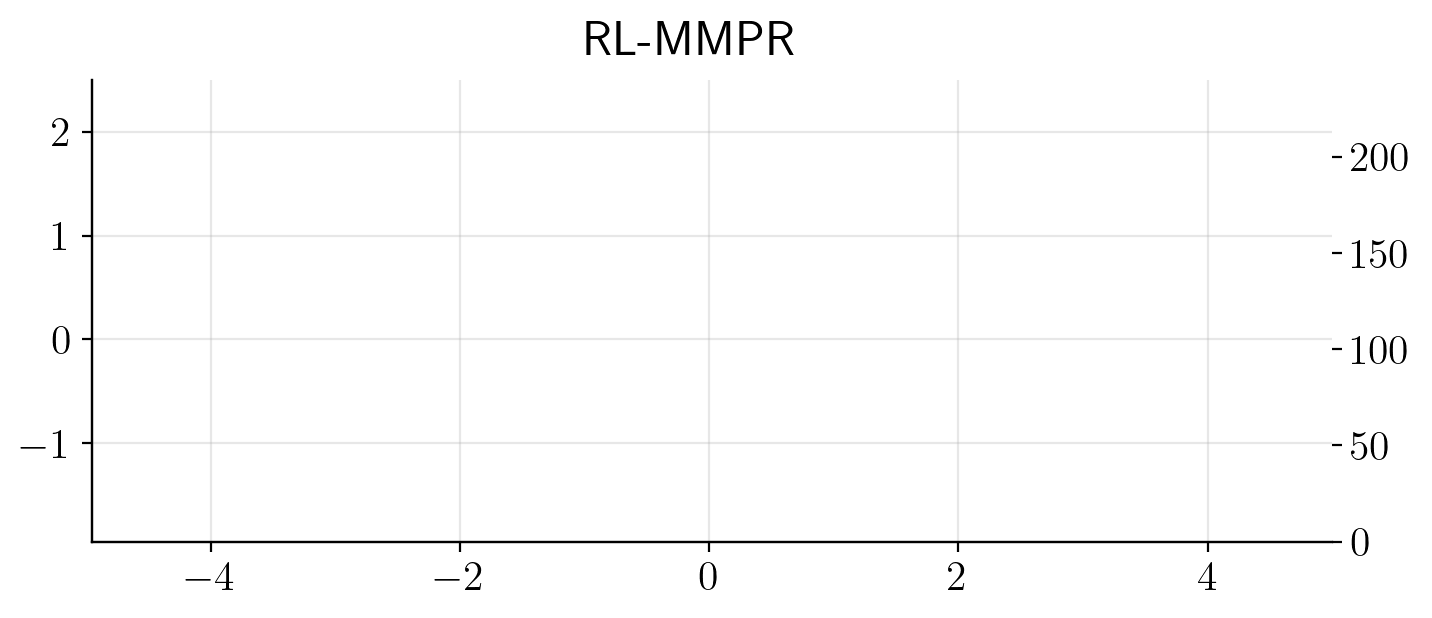

In [52]:
fig, ax = plt.subplots(figsize=(8.0, 3.0))
ax2 = ax.twinx()

markersize = 10
method = "RL-MMPR"
yhat, yminv, ymaxv, expected_runlength = jax.tree.map(np.array, package[method])

def animate(t):
    print(t, end="\r")
    ax.cla()
    ax2.cla()
    xsub = x[:t]
    ysub = y[:t]
    
    yhat_sub = yhat[:t]
    ymin_sub, ymax_sub = yminv[:t], ymaxv[:t]
    rl_sub = expected_runlength[:t]

    # plt.sca(ax)
    ax.scatter(xsub, ysub, s=markersize, c="orange")
    ax.plot(xsub, yhat_sub, linewidth=1, label="y-hat", c="black")
    ax.fill_between(xsub, ymin_sub, ymax_sub, color="gray", alpha=0.3)
    ax.set_ylim(ymin, ymax)
    
    ax2.plot(xsub, rl_sub, c="red", alpha=0.7)
    ax.grid(alpha=0.3)
    ax.set_xlim(x.min(), x.max())
    ax2.set_ylim(0, expected_runlength.max())
    plt.suptitle(method)

frames = np.arange(560)
animation = FuncAnimation(fig, animate, frames)
animation.save(f"../figures/{method}-test.gif", fps=30)

In [53]:
markersize = 10

def animate(t):
    print(t, end="\r")
    xsub = np.array(x[:t])
    # ysub = y[:t]
    ysub = np.array(y_clean[:t])


    for ax, ax2, method in zip(axs, axs2, package):
        ax.cla()
        ax2.cla()
        yhat, yminv, ymaxv, expected_runlength = package[method]
        
        yhat_sub = yhat[:t]
        ymin_sub, ymax_sub = yminv[:t], ymaxv[:t]
        rl_sub = expected_runlength[:t]
    
        # ax.scatter(xsub, ysub, s=markersize, c="orange", label="y")
        ax.plot(xsub, ysub, c="orange", label="y", linewidth=2)
        ax.plot(xsub, yhat_sub, linewidth=1, label="y-hat", c="black")
        ax.fill_between(xsub, ymin_sub, ymax_sub, color="gray", alpha=0.3)
        ax.set_ylim(ymin, ymax)
        
        l3 = ax2.plot(xsub, rl_sub, c="red", alpha=0.7, label="runlenght")
        
        ax.grid(alpha=0.3)
        ax.set_xlim(x.min(), x.max())
        ax2.set_ylim(0, expected_runlength.max())
        method = method + "*" if "OUPR" in method else method
        ax.set_ylabel(method, fontsize=12)
        if "OUPR" in method:
            ax.set_xlabel("timestep ($x_t$)")
            ax.legend(loc="upper left", fontsize=10)
            ax2.legend(loc="upper right", fontsize=10)

        for partition in np.array(partitions):
            if partition <= t:
                ax.axvline(x=x[partition], c="black", linestyle="--", linewidth=2)
        
        plt.tight_layout()

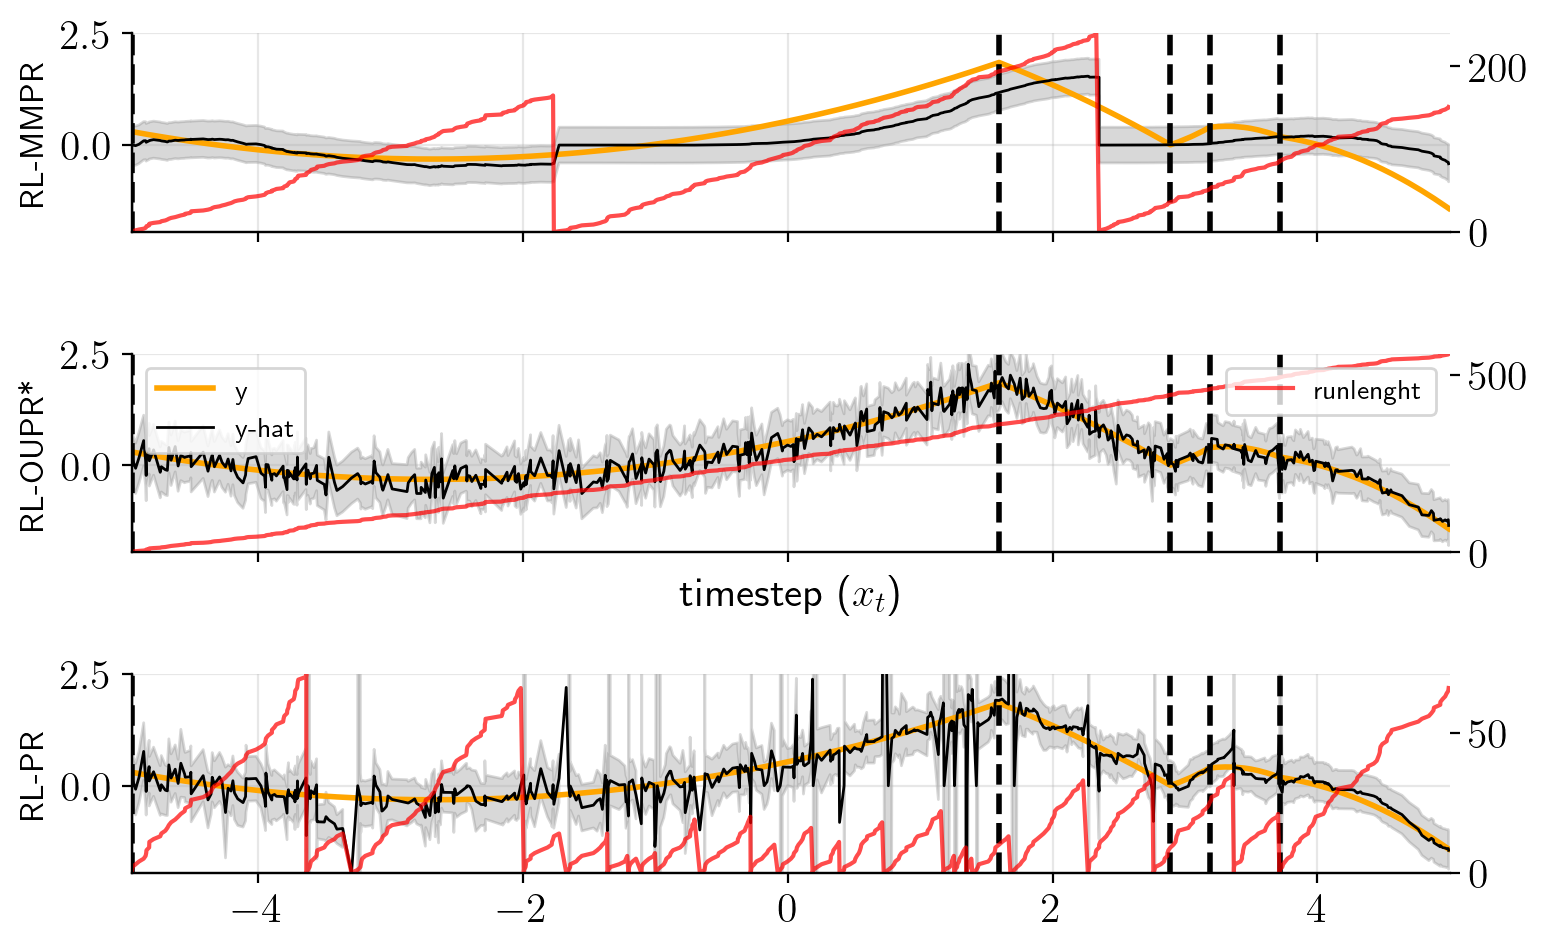

In [54]:
fig, axs = plt.subplots(3, 1, figsize=(8.0, 5.0), sharex=True)
axs2 = [ax.twinx() for ax in axs]
animate(559)
plt.savefig("../figures/segment-dependency-test-all.png", dpi=300, bbox_inches="tight")

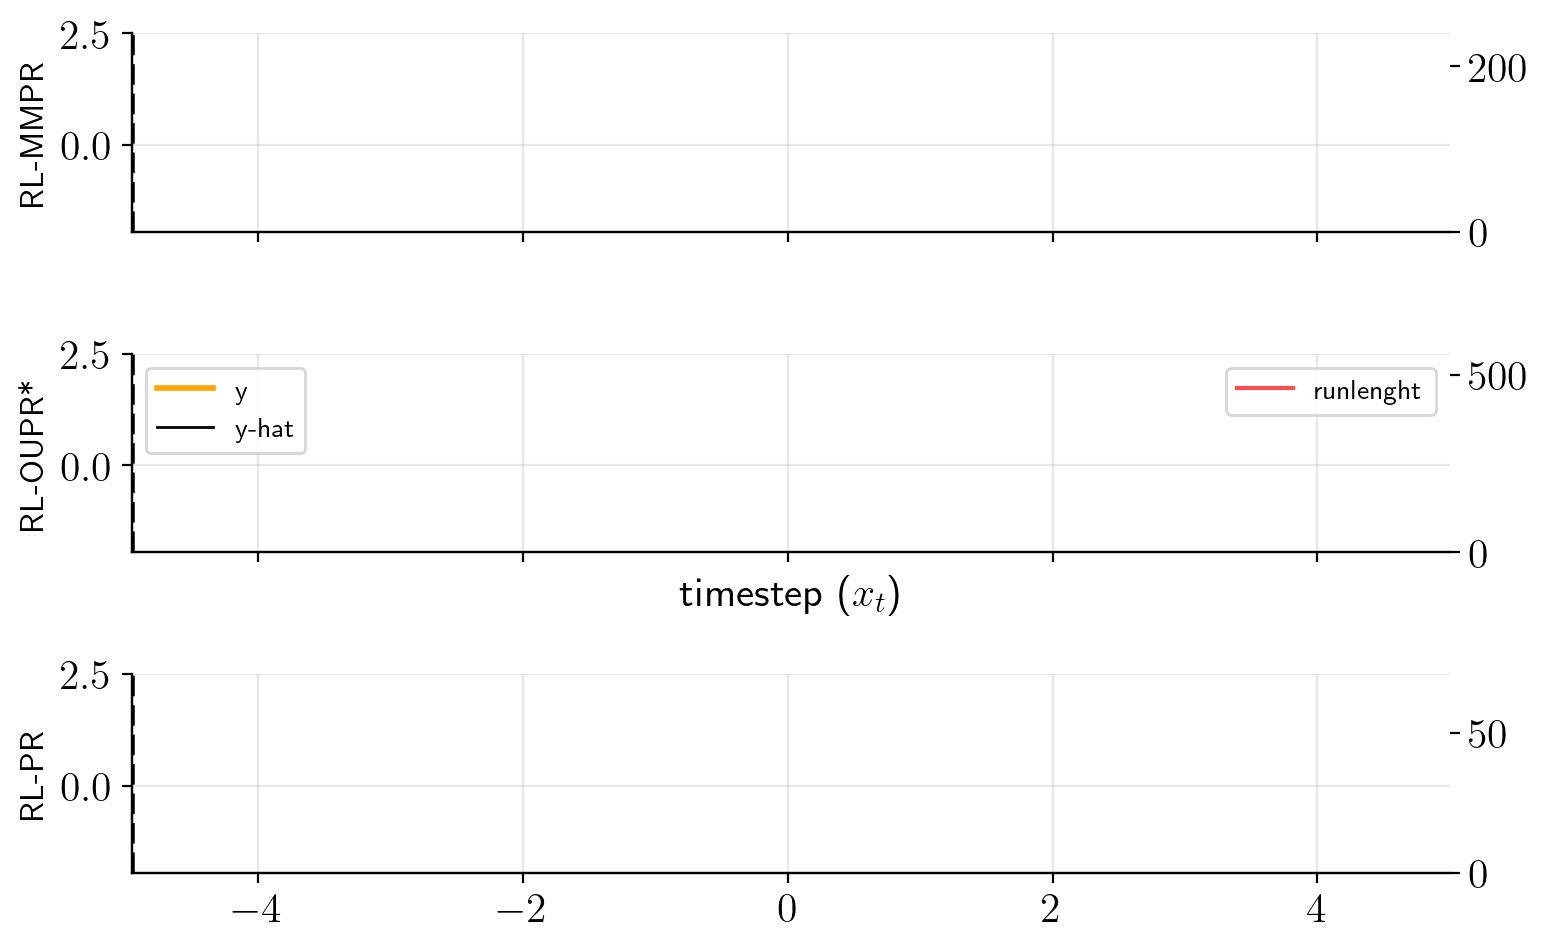

In [55]:
fig, axs = plt.subplots(3, 1, figsize=(8.0, 5.0), sharex=True)
axs2 = [ax.twinx() for ax in axs]

frames = np.arange(560)
animation = FuncAnimation(fig, animate, frames)
animation.save(f"../figures/all-test.gif", fps=30)

----


# Multiple runs

In [56]:
key = jax.random.PRNGKey(314)
key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

In [57]:
p = 0.01
n_partitions = 5
partitions = sample_partitions(key_partition, p, n_partitions)
n_samples = partitions[-1]
x = sample_covariates(key_x, n_samples)
y, y_clean = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=0.2, n_power=3)
pair_partitions = list(zip(partitions[:-1], partitions[1:]))

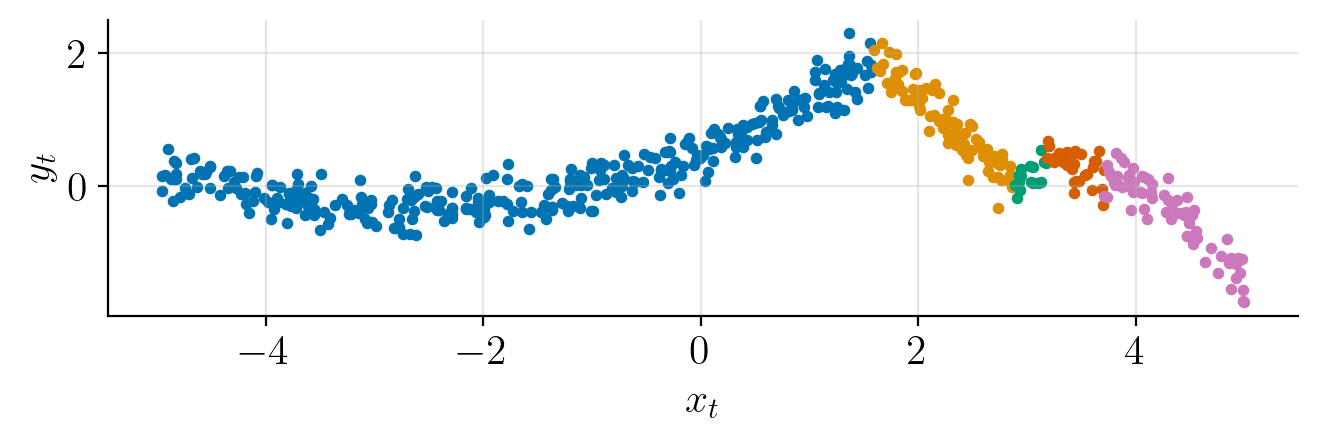

In [58]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))

colors = sns.color_palette()
for i, (ix_init, ix_end) in enumerate(pair_partitions):
        c = colors[i]
        plt.scatter(x[ix_init:ix_end], y[ix_init:ix_end], s=10)
plt.xlabel("$x_t$")
plt.ylabel("$y_t$")
ymin, ymax = plt.ylim()
plt.grid(alpha=0.3)

In [59]:
# @jax.jit
def filter_cst(y, x, obs_variance):
    def apply_fn(mean, x):
        delta = x - x[-1]
        phi = jnp.array([delta ** 0, delta ** 1, delta ** 2])
        return mean @ phi

    def callback(bel, bel_prior, y, X):
        pred = apply_fn(bel_prior.mean, X)
        
        out = {
            "err": pred - y,
            "yhat": pred
        }
        return out
        
    filter = ExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0

    bel_init = filter.init_bel(mean, cov)
    bel_final, hist = filter.scan(bel_init, y[:, None], x[:, None], callback)
    return hist


# @jax.jit
def filter_rlpr(y, x, p_change, obs_variance, K=1):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = GaussPositionRLPR(p_change, K=K, filter=filter, moment_match=False)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


# @jax.jit
def filter_rlmmpr(y, x, p_change, obs_variance, K=1):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = GaussPositionRLPR(p_change, K=K, filter=filter, moment_match=True)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


# @jax.jit
def filter_rlspr(y, x, p_change, obs_variance, threshold):
    filter = BeliefExtendedKalmanFilter(
        lambda x: x, apply_fn, jnp.eye(3) * 0.0, observation_covariance=obs_variance
    )
    a_filter = SoftPiecewiseRLPR(p_change, filter=filter, deflate_mean=True, threshold=threshold)
    
    mean = jnp.zeros(3)
    cov = jnp.eye(3) * 1.0
    
    bel_init = a_filter.init_bel(mean, cov, 0.0, x[-1])
    bel_final, hist = a_filter.scan(y[:, None], x[:, None], bel_init, callback)
    return hist


In [60]:
p_change = 0.01
obs_variance = 0.2 ** 2

In [61]:
hist_static = filter_cst(y, x, obs_variance)
hist_rlpr = filter_rlpr(y, x, p_change, obs_variance)
hist_rlmmpr = filter_rlmmpr(y, x, p_change, obs_variance)
hist_rlspr = filter_rlspr(y, x, p_change, obs_variance, threshold=1/2)

In [62]:
jnp.sqrt(jnp.power(hist_static["err"], 2).mean())

Array(0.703442, dtype=float32)

In [63]:
jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean())

Array(0.8624169, dtype=float32)

In [64]:
jnp.sqrt(jnp.power(hist_rlmmpr["err"], 2).mean())

Array(0.45395893, dtype=float32)

In [65]:
jnp.sqrt(jnp.power(hist_rlspr["err"], 2).mean())

Array(0.27549142, dtype=float32)

## Multiple keys

In [66]:
p = 0.01
n_sims = 100
n_partitions = 5
key_init = jax.random.PRNGKey(314)
threshold = 1/2
errs = []
changepoints = []

for s in tqdm(range(n_sims)):
    key = jax.random.fold_in(key_init, s)
    key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

    partitions = sample_partitions(key_partition, p, n_partitions)
    n_samples = partitions[-1]
    x = sample_covariates(key_x, n_samples)
    y, y_clean = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=0.2, n_power=3)
    pair_partitions = list(zip(partitions[:-1], partitions[1:]))


    hist_static = filter_cst(y, x, obs_variance)
    hist_rlpr = filter_rlpr(y, x, p_change, obs_variance)
    hist_rlmmpr = filter_rlmmpr(y, x, p_change, obs_variance)
    hist_rlspr = filter_rlspr(y, x, p_change, obs_variance, threshold)

    changepoints.append({
        "C-F": 0.0,
        "RL[1]-PR": (hist_rlpr["runlength"] == 0).sum(),
        "RL[1]-MMPR": (hist_rlmmpr["runlength"] == 0).sum(),
        "RL[1]-OUPR": (hist_rlspr["runlength"] == 0).sum(),
    })

    errs.append({
        "C-F": jnp.sqrt(jnp.power(hist_static["err"], 2).mean()),
        "RL[1]-PR": jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean()),
        "RL[1]-MMPR": jnp.sqrt(jnp.power(hist_rlmmpr["err"], 2).mean()),
        "RL[1]-OUPR": jnp.sqrt(jnp.power(hist_rlspr["err"], 2).mean()),
    })

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


In [67]:
errs_df = jax.tree.map(np.array, errs)
errs_df = pd.DataFrame(errs)
errs_df = errs_df.rename({"RL-OUPR":"RL-OUPR*"}, axis=1)
errs_df = errs_df.astype(float)

In [68]:
count_df = jax.tree.map(np.array, changepoints)
count_df = pd.DataFrame(count_df).astype(int)
count_df = count_df.rename({"RL-SPR": "RL-OUPR*"}, axis=1)
count_df.describe()

,C-F,RL[1]-MMPR,RL[1]-OUPR,RL[1]-PR
count,100.0,100.000000,100.0000,100.000000
mean,0.0,9.150000,1.5200,28.840000
std,0.0,11.137683,0.6739,10.761623
min,0.0,1.000000,0.0000,8.000000
25%,0.0,2.000000,1.0000,21.750000
50%,0.0,5.000000,2.0000,27.500000
75%,0.0,11.000000,2.0000,35.500000
max,0.0,61.000000,3.0000,59.000000


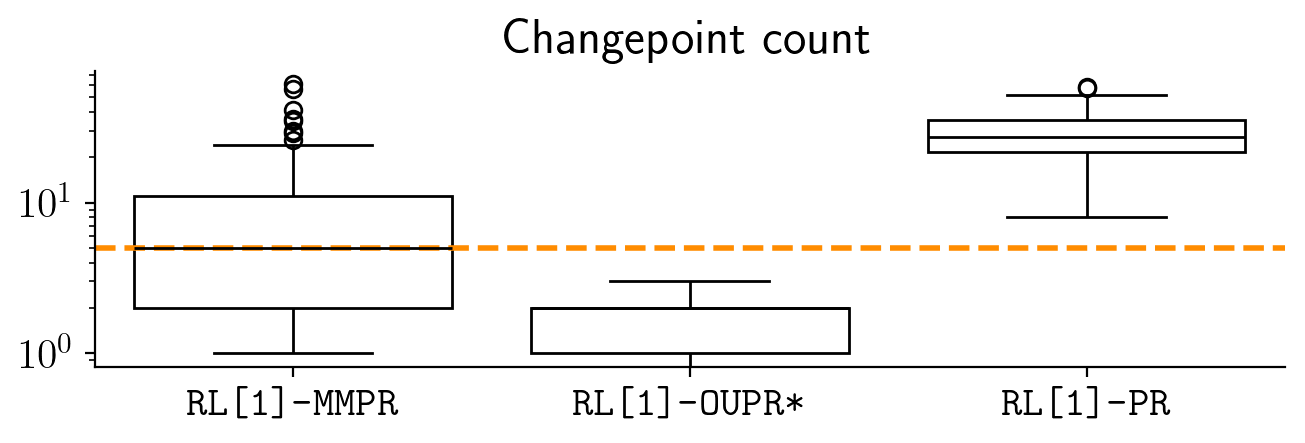

In [69]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.4))


sns.boxplot(
    x="variable",
    y="value",
    data=(count_df).drop("C-F", axis=1).melt(),
    color="white",
    linecolor="black",
)

pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = label + "*" if "OUPR" in label else label
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)


plt.xlabel("")
plt.ylabel("")
plt.title("Changepoint count")
plt.yscale("log")
plt.axhline(y=5, c="darkorange", linestyle="--", linewidth=2)
plt.savefig("../figures/segment-count.png", dpi=300, bbox_inches="tight")

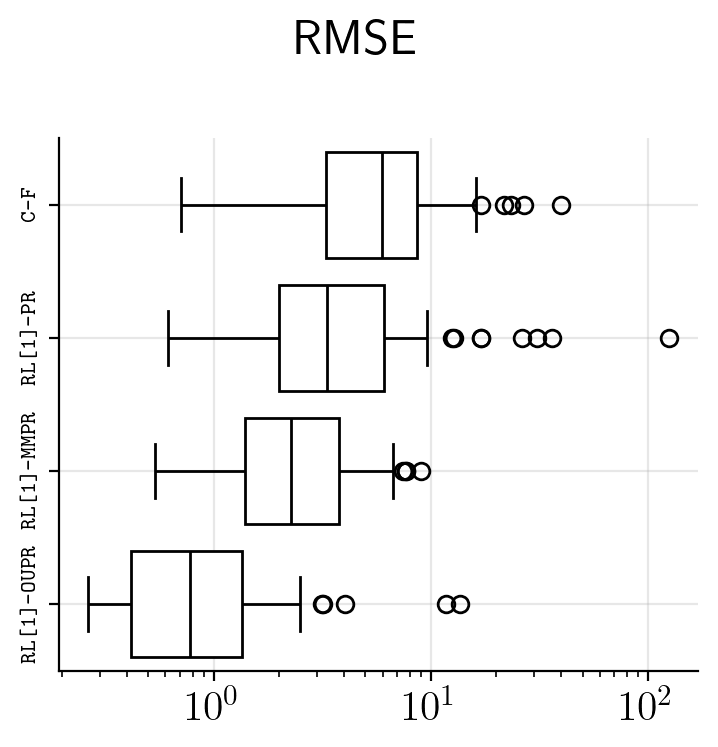

In [70]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2 * 0.5, 4.8 * 0.8))

sns.boxplot(
    y="variable",
    x="value",
    data=errs_df.rename({c: r"\texttt{" + c + "}" for c in errs_df}, axis=1).melt(),
    color="white",
    linecolor="black",
)

plt.grid(alpha=0.3)
plt.xscale("log")

pos, ticks = plt.yticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.yticks(pos, newlabels)


plt.yticks(rotation=90, fontsize=8, verticalalignment="center")
plt.suptitle("RMSE")
plt.yticks()
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.savefig("../figures/segment-dependency-result.png", dpi=300, bbox_inches="tight")

## Increasing number of hypotheses

In [64]:
p = 0.01
n_sims = 100
n_partitions = 5
key_init = jax.random.PRNGKey(314)
threshold = 1/2
errs_k = []
changepoints_k = []

for s in tqdm(range(n_sims)):
    key = jax.random.fold_in(key_init, s)
    key_x, key_partition, keys_noise, keys_params = jax.random.split(key, 4)

    partitions = sample_partitions(key_partition, p, n_partitions)
    n_samples = partitions[-1]
    x = sample_covariates(key_x, n_samples)
    y, y_clean = sample_measurements(keys_noise, keys_params, partitions, x, std_measurement=0.2, n_power=3)
    pair_partitions = list(zip(partitions[:-1], partitions[1:]))

    changepoints_part = {}
    errs_part = {}

    # 1
    for K in [1, 5, 10, 15]:
        hist_rlpr = filter_rlpr(y, x, p_change, obs_variance, K)
        hist_rlmmpr = filter_rlmmpr(y, x, p_change, obs_variance, K)
        changepoints_part = {
            f"RL[{K}]-PR": (hist_rlpr["runlength"] == 0).sum(),
            f"RL[{K}]-MMPR": (hist_rlmmpr["runlength"] == 0).sum(),
            **changepoints_part
        }

        errs_part = {
            f"RL[{K}]-PR": jnp.sqrt(jnp.power(hist_rlpr["err"], 2).mean()),
            f"RL[{K}]-MMPR": jnp.sqrt(jnp.power(hist_rlmmpr["err"], 2).mean()),
            **errs_part
        }

    changepoints_k.append(changepoints_part)
    errs_k.append(errs_part)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [09:15<00:00,  5.56s/it]


In [65]:
count_df = jax.tree.map(np.array, changepoints_k)
count_df = pd.DataFrame(count_df).astype(int)
count_df = count_df.rename({"RL-SPR": "RL-OUPR*"}, axis=1)
count_df.describe()

,RL[10]-MMPR,RL[10]-PR,RL[15]-MMPR,RL[15]-PR,RL[1]-MMPR,RL[1]-PR,RL[5]-MMPR,RL[5]-PR
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,502.180000,509.110000,508.720000,513.680000,9.150000,28.840000,490.340000,480.580000
std,208.535702,211.088085,209.666935,211.821245,11.137683,10.761623,210.289758,196.675921
min,119.000000,119.000000,123.000000,124.000000,1.000000,8.000000,119.000000,116.000000
25%,360.250000,356.750000,363.250000,362.250000,2.000000,21.750000,338.000000,347.000000
50%,486.500000,495.000000,489.500000,498.000000,5.000000,27.500000,482.500000,460.000000
75%,647.250000,649.000000,657.250000,655.000000,11.000000,35.500000,631.250000,615.000000
max,1196.000000,1190.000000,1196.000000,1195.000000,61.000000,59.000000,1196.000000,1059.000000


In [67]:
count_df[[c for c in count_df if "MM"  in c]].mean()

RL[10]-MMPR    502.18
RL[15]-MMPR    508.72
RL[1]-MMPR       9.15
RL[5]-MMPR     490.34
dtype: float64

In [68]:
count_df[[c for c in count_df if "MM"  not in c]].mean()

RL[10]-PR    509.11
RL[15]-PR    513.68
RL[1]-PR      28.84
RL[5]-PR     480.58
dtype: float64

In [74]:
errs_df = jax.tree.map(np.array, errs_k)
errs_df = pd.DataFrame(errs_df)
errs_df = errs_df.rename({"RL-OUPR":"RL-OUPR*"}, axis=1)
errs_df = errs_df.astype(float)

In [76]:
errs_df[[c for c in count_df if "MM"  in c]].mean()

RL[10]-MMPR    2.189571
RL[15]-MMPR    2.087370
RL[1]-MMPR     2.874580
RL[5]-MMPR     2.217153
dtype: float64

In [77]:
errs_df[[c for c in count_df if "MM"  not in c]].mean()

RL[10]-PR    3.512336
RL[15]-PR    3.728326
RL[1]-PR     6.085980
RL[5]-PR     3.925389
dtype: float64

In [75]:
errs_df.describe()

,RL[10]-MMPR,RL[10]-PR,RL[15]-MMPR,RL[15]-PR,RL[1]-MMPR,RL[1]-PR,RL[5]-MMPR,RL[5]-PR
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.189571,3.512336,2.087370,3.728326,2.874580,6.085980,2.217153,3.925389
std,2.347250,6.682182,1.812190,7.104443,1.924163,13.269871,2.389196,8.155515
min,0.461929,0.495815,0.464821,0.460468,0.539419,0.616285,0.474529,0.472046
25%,0.895327,1.177215,0.892886,1.090020,1.400688,1.992488,0.960069,1.230200
50%,1.275755,2.148546,1.250921,1.950803,2.267536,3.309536,1.266659,2.272516
75%,2.545689,3.530934,2.722867,3.371076,3.766656,6.062928,2.872602,3.399052
max,17.569996,64.408669,10.081306,64.287849,9.020914,125.024460,17.569994,64.482140
